# HW 5

### 1. Conceptual Questions

**(a) Given two tables, calculate the mutual information for the two keywords, "prize" and "hello". Which keyword is more informative for deciding whether or not the email is a spam?**

||spam = 1|spam = 0|
|:-:|:-:|:-:|
|**prize = 1** | $N_{11}$ = 150 | $N_{10}$ = 1000 |
|**prize = 0** |$N_{01}$ = 10 | $N_{00}$ = 15000 |

||spam = 1|spam = 0|
|:-:|:-:|:-:|
|**hello = 1** | $N_{11}$ = 155 | $N_{10}$ = 14000 |
|**hello = 0** |$N_{01}$ = 5 | $N_{00}$ = 2000 |

In [460]:
import math

N = 150+1000+10+15000
N11 = 150 
N10 = 1000
N01 = 10
N00 = 15000
N1_ = 150+1000
N_1 = 150+10
N0_ = 10+15000
N_0 = 1000+15000

prize_spam = (N11/N)*math.log((N*N11)/(N1_*N_1),2) +(N01/N)*math.log((N*N01)/(N0_*N_1),2) + (N10/N)*math.log((N*N10)/(N1_*N_0),2) + (N00/N)*math.log((N*N00)/(N0_*N_0),2)
print(prize_spam)

0.03296011876395397


In [461]:
N = 155+14000+5+2000
N11 = 155 
N10 = 14000
N01 = 5
N00 = 2000
N1_ = 155+14000
N_1 = 155+5
N0_ = 5+2000
N_0 = 14000+2000

hello_spam = (N11/N)*math.log((N*N11)/(N1_*N_1),2) +(N01/N)*math.log((N*N01)/(N0_*N_1),2) + (N10/N)*math.log((N*N10)/(N1_*N_0),2) + (N00/N)*math.log((N*N00)/(N0_*N_0),2)
print(hello_spam)

0.0007839352232340266


**(b) Plot the CUSUM statistic for a sequence of randomly generated samples that are i.i.d $x_1,...,x_{100} \backsim f_0, x_{101},...,x_{200} \backsim f_1$**

In [462]:
# Generate samples
np.random.seed(4624)

f_0 = np.random.normal(0, 1, 100)
f_1 = np.random.normal(1.5, np.sqrt(1.1), 100)

s = []

for i in f_0:
    s.append(i)
for i in f_1:
    s.append(i)

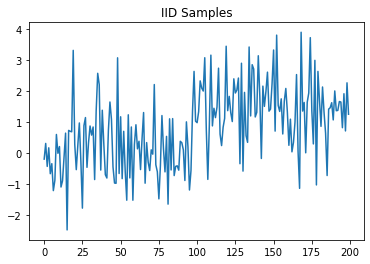

In [463]:
plt.plot(s)
plt.title("IID Samples")
plt.savefig('cusum_samples.jpg')

In [464]:
# Create W_t calculation
from scipy.stats import norm

def w_t(x):
    
    f_0 = norm(0,1).pdf(x)
    f_1 = norm(1.5,np.sqrt(1.1)).pdf(x)
    return math.log(f_1/f_0)

In [465]:
# Calculate CUSUM stat
w = [0]

for i in range(1, len(s)+1):
    w_prev = w[i-1]   
    w_current = w_prev + max(w_t(s[i-1]), 0)
    w.append(w_current)

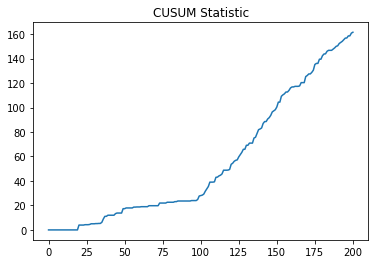

In [466]:
plt.plot(w)
plt.title('CUSUM Statistic')
plt.savefig('cusum_statistic.jpg')

### 2. House Price Dataset
The HOUSES dataset contains a collection of recent real estate listings in San Luis Obispo county and around it. The dataset is provided in RealEstate.csv. You may use “one-hot-keying” to expand the categorical variables.  
The dataset contains the following useful fields (You may exclude the Location and MLS in your linear regression model).  
You can use any package for this question.  
Note: We suggest you scale the independent variables (but not the dependent variable). We also suggest you use our suggested seeds, as this dataset is particularly seed dependent.  
* Price: the most recent listing price of the house (in dollars).
* Bedrooms: number of bedrooms.
* Bathrooms: number of bathrooms.
* Size: size of the house in square feet.
* Price/SQ.ft: price of the house per square foot.
* Status: Short Sale, Foreclosure and Regular.

In [467]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, lasso_path, lars_path
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import random

In [468]:
houses = pd.read_csv('data/RealEstate.csv') 

# Remove MLS and Location
houses = houses[['Price', 'Bedrooms', 'Size', 'Price/SQ.Ft', 'Status']]

# One Hot Encoding for Status
# https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd

enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(houses[['Status']]).toarray().astype(int))
houses = houses.join(enc_df)

# Rename Columns
houses.rename(columns={0: 'Foreclosure', 1: 'Regular', 2: 'Short Sale'}, inplace = True)

# Drop Status column and separate X and y
houses = houses[['Price', 'Bedrooms', 'Size', 'Price/SQ.Ft', 'Foreclosure', 'Regular', 'Short Sale']]
houses_X = houses[['Bedrooms', 'Size', 'Price/SQ.Ft', 'Foreclosure', 'Regular', 'Short Sale']]
houses_y = houses['Price']

In [469]:
# Scale the independent variables and keep one hot encoding
# https://www.askpython.com/python/examples/standardize-data-in-python

scaler = MinMaxScaler(feature_range=(0, 1))
houses_X_scaled = pd.DataFrame(scaler.fit_transform(houses_X))

**(a)  Fit the Ridge regression model to predict Price from all variable. You can use one-hot keying to expand the categorical variable Status. Use 5-fold cross validation to select the regularizer optimal parameter, and show the CV curve. Report the fitted model (i.e., the parameters), and the sum-of-squares residuals. The suggested search range for the regularization parameter is from 1 to 80, and the suggested seed is 2.**

In [470]:
# https://machinelearningmastery.com/ridge-regression-with-python/

# define model
model = Ridge()

# define model evaluation method
cv = KFold(n_splits=5, random_state=2, shuffle=True)

# define grid
grid = dict()
grid['alpha'] = np.arange(1, 81)

# define search
search = GridSearchCV(model, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# perform the search
results = search.fit(houses_X_scaled, houses_y)
best_alpha = results.best_params_['alpha']
print('Best Alpha: ' + str(best_alpha))

Best Alpha: 1


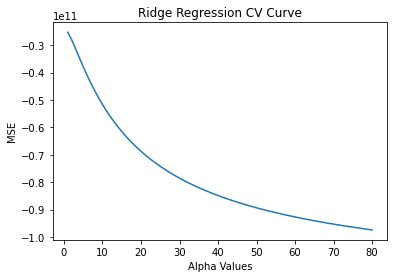

In [471]:
mse = results.cv_results_['mean_test_score']
plt.plot(grid['alpha'],mse)
plt.ylabel('MSE')
plt.xlabel('Alpha Values')
plt.title('Ridge Regression CV Curve')
plt.savefig('house_ridge_cv_curve.jpg')

In [472]:
# Fit the Ridge Regression Model
final_model = Ridge(alpha = best_alpha)

final_model.fit(houses_X_scaled,houses_y)

final_coefficients = final_model.coef_
final_intercept = final_model.intercept_
print('Coefficients: ' + str(final_coefficients))
print('Intercept: ' + str(final_intercept))

Coefficients: [  24264.47041987 1579560.26950984 1849370.30103488  -15396.50807562
   40911.75979374  -25515.25171813]
Intercept: -314766.34852713783


In [473]:
# Sum of Squares Residuals
y_pred = final_model.predict(houses_X_scaled)
SSR = sum((houses_y - y_pred)**2)
print('SSR: ' + str(SSR))

SSR: 17003281203675.037


**(b) Use lasso to select variables. Use 5-fold cross validation to select the regularizer optimal parameter, and show the CV curve. Report the fitted model (i.e., the parameters selected and their coefficient). Show the Lasso solution path. The suggested search range for the regularization parameter is from 1 to 3000, and the suggested seed is 3.**

In [474]:
# define model
model = Lasso()

# define model evaluation method
cv = KFold(n_splits=5, random_state=3, shuffle=True)

# define grid
grid = dict()
grid['alpha'] = np.arange(1, 3001)

# define search
search = GridSearchCV(model, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# perform the search
results = search.fit(houses_X_scaled, houses_y)
best_alpha = results.best_params_['alpha']
print('Best Alpha: ' + str(best_alpha))

Best Alpha: 11


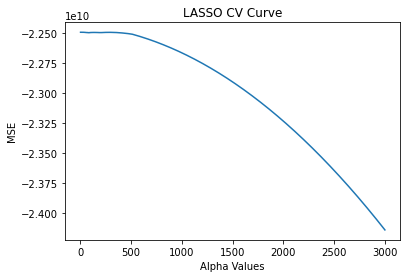

In [475]:
# CV Curve
mse = results.cv_results_['mean_test_score']
plt.plot(grid['alpha'],mse)
plt.ylabel('MSE')
plt.xlabel('Alpha Values')
plt.title('LASSO CV Curve')
plt.savefig('house_lasso_cv_curve.jpg')

In [476]:
# Fit the LASSO Model
final_model = Lasso(alpha = best_alpha)

final_model.fit(houses_X_scaled,houses_y)

final_coefficients = final_model.coef_
final_intercept = final_model.intercept_
print('Coefficients: ' + str(final_coefficients))
print('Intercept: ' + str(final_intercept))

Coefficients: [ -71614.75646417 1741200.2885389  2074627.53267139    4610.26062518
   33538.84775991   -4583.3327755 ]
Intercept: -380005.4024880027


In [477]:
# Sum of Squares Residuals
y_pred = final_model.predict(houses_X_scaled)
SSR = sum((houses_y - y_pred)**2)
print('SSR: ' + str(SSR))

SSR: 16330843510219.453


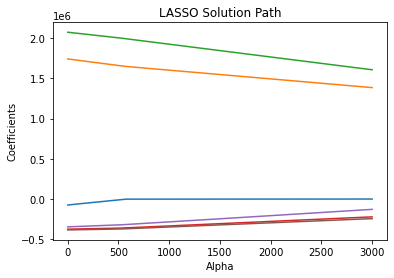

In [478]:
# Lasso Solution Path
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py
eps = 5e-3  # the smaller it is the longer is the path
alphas_lasso, coefs_lasso, _ = lasso_path(houses_X_scaled, houses_y, eps=eps, alphas = np.arange(1, 3001))

plt.plot(alphas_lasso, coefs_lasso.T)
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('LASSO Solution Path')
plt.savefig('house_lasso_solution_path.jpg')

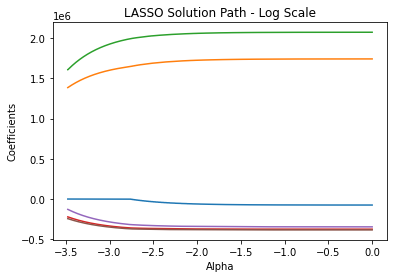

In [479]:
plt.plot(-np.log10(alphas_lasso), coefs_lasso.T)
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('LASSO Solution Path - Log Scale')
plt.savefig('house_lasso_solution_path_log.jpg')

### 3. Medical Imaging Reconstuction

In [480]:
import scipy.io as spio
import time

In [481]:
# Import Data
mri = spio.loadmat('data/cs.mat',squeeze_me=True)['img']
x = mri.reshape((50*50))

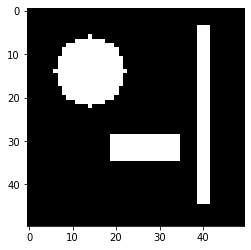

In [482]:
plt.imshow(mri, cmap='gray')
plt.savefig('mri_original_img.jpg')

**(a) Use Lasso to recover the image and select $\lambda$ using 10-fold cross validation. Plot the cross-validation error curves and show the recovered image.**

To find lambda, I tested multiple ranges and found that smaller values (< 1) of lambda worked best. 

In [499]:
# Initialize variables
A = np.random.normal(0, 1, (1300,2500))
eps = np.random.normal(0, np.sqrt(25), (1300,1))
y = (A@x).reshape((1300,1)) + eps

In [502]:
start = time.time()

# define model
model = Lasso(tol = 1e-8, max_iter = 100000)

# define model evaluation method
# cv = RepeatedKFold(n_splits=5, random_state=2)
cv = KFold(n_splits=10, random_state=5, shuffle=True)

# define grid
grid = dict()
# grid['alpha'] = np.arange(0.01, 1.01, 0.01)
grid['alpha'] = np.arange(0.04, 0.71, 0.01)

# define search
search = GridSearchCV(model, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# perform the search
results = search.fit(A, y)
best_alpha = results.best_params_['alpha']
print('Best Alpha: ' + str(best_alpha))

end = time.time()
print("Run Time = " + str(end - start))

Best Alpha: 0.07
Run Time = 226.6814830303192


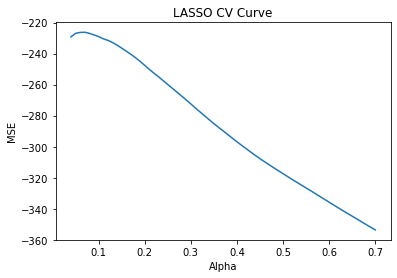

In [503]:
# CV Curve
mse = results.cv_results_['mean_test_score']
plt.plot(grid['alpha'],mse)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('LASSO CV Curve')
plt.savefig('mri_lasso_cv_curve.jpg')

In [504]:
# Fit the LASSO Model
final_model = Lasso(alpha = 0.5)

final_model.fit(A,y)

final_coefficients = final_model.coef_
final_intercept = final_model.intercept_
print('Coefficients: ' + str(final_coefficients))
print('Intercept: ' + str(final_intercept))

Coefficients: [ 0.  0. -0. ... -0.  0. -0.]
Intercept: [-0.00301025]


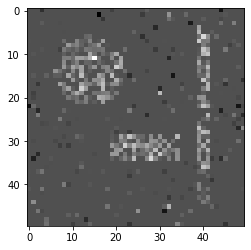

In [505]:
lasso_img = (final_coefficients).reshape(50,50)
plt.imshow(lasso_img, cmap='gray')
plt.savefig('mri_lasso_img.jpg')

**(b) To compare, use ridge regression to recover the image. Use $\lambda$ using 10-fold cross validation. Plot the cross-validation error curves and show the recovered image.**  

In [512]:
start = time.time()

# define model
model_rr = Ridge()

# define model evaluation method
cv_rr = KFold(n_splits=10, random_state=5, shuffle=True)

# define grid
grid_rr = dict()
grid_rr['alpha'] = np.arange(1, 100, 1)

# define search
search_rr = GridSearchCV(model_rr, grid_rr, scoring='neg_mean_squared_error', cv=cv_rr, n_jobs=-1)

# perform the search
results_rr = search_rr.fit(A, y)
best_alpha_rr = results_rr.best_params_['alpha']
print('Best Alpha: ' + str(best_alpha_rr))

end = time.time()
print("Run Time = " + str(end - start))

Best Alpha: 61
Run Time = 124.6295759677887


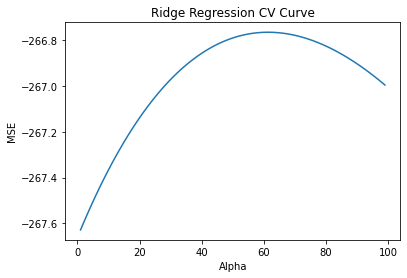

In [513]:
# CV Curve
mse = results_rr.cv_results_['mean_test_score']
plt.plot(grid['alpha'],mse)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Ridge Regression CV Curve')
plt.savefig('mri_ridge_cv_curve.jpg')

In [514]:
# Fit the Ridge Regression Model
final_model = Ridge(alpha = best_alpha_rr)

final_model.fit(A,y)

final_coefficients = final_model.coef_
final_intercept = final_model.intercept_
print('Coefficients: ' + str(final_coefficients))
print('Intercept: ' + str(final_intercept))

Coefficients: [[ 0.40548691  0.13210255  0.01099153 ... -0.27576392  0.17908001
  -0.09231775]]
Intercept: [-0.34061972]


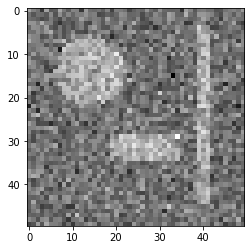

In [515]:
ridge_img = (final_coefficients).reshape(50,50)
plt.imshow(ridge_img, cmap='gray')
plt.savefig('mri_ridge_img.jpg')